Сначала скачаем, засунем в dataframe данные

In [ ]:
import pandas as pd
url = r'C:\Projects\Neo4j\data\System_unit.cvs'
df = pd.read_csv(url, header=None)
df.columns = [u'value',
              u'core_number',
              u'frequency',
              u'value_video',
              u'shina',
              u'volume_hdd',
             'Class']

In [53]:
df.shape

(12500, 7)

In [54]:
df.head

<bound method NDFrame.head of        value  core_number  frequency  value_video  shina  volume_hdd  Class
0          4            8        3.2          4.0    128         120    AMD
1          4            8        3.2          4.0    128         128    AMD
2          4            8        3.2          4.0    128         240    AMD
3          4            8        3.2          4.0    128         120    AMD
4          4            8        3.2          4.0    128          60    AMD
5          4            8        3.2          4.0    128         120    AMD
6          4            8        3.2          4.0    128         240    AMD
7          4            8        3.2          4.0    128         120    AMD
8          4            8        3.2          4.0    128         120    AMD
9          4            8        3.2          4.0    128         128    AMD
10         4            8        3.2          4.0    128         256    AMD
11         4            8        3.2          4.0    128  

In [61]:
df.describe()

,value,core_number,frequency,value_video,shina,volume_hdd
count,12500.00000,12500.000000,12500.000000,12500.00000,12500.000000,12500.000000
mean,10.00000,4.300000,3.460000,3.50000,147.200000,168.880000
std,6.00024,2.304436,0.410382,1.86555,66.513412,64.142613
min,4.00000,2.000000,2.700000,0.50000,32.000000,60.000000
25%,4.00000,2.000000,3.275000,2.00000,128.000000,120.000000
50%,10.00000,4.000000,3.500000,4.00000,128.000000,128.000000
75%,16.00000,6.000000,3.725000,4.00000,192.000000,240.000000
max,16.00000,8.000000,4.200000,8.00000,256.000000,256.000000


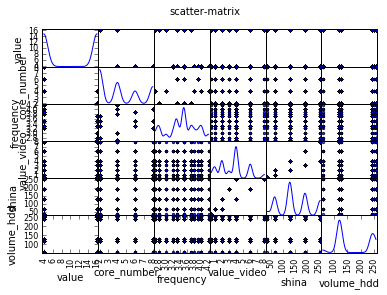

In [60]:
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df, alpha=0.05, diagonal='kde');
plt.suptitle('scatter-matrix')

plt.show()

Делим данные на две части: тренирововчную и тестовую с прапорцией 20/80

In [46]:
import numpy as np
def test_and_train(df, proportion):
    mask = np.random.rand(len(df)) < proportion
    return df[mask], df[~mask]
train, test = test_and_train(df, 0.2)

Теперь нужно каким-то образом научиться определять ближайших соседей. Для этого используется Евклидово расстояние.

In [47]:
from math import sqrt
def euclidean_distance(instance1,instance2):
    squares = [(i-j)**2 for i,j in zip(instance1,instance2)]
    return sqrt(sum(squares))

Считаем дистанцию до всех записей в тренировочном сете, сортирует их по возрастанию и возвращает k ближайших соседей

In [48]:
import operator
def get_neighbours(instance, train,k):
    distances = []
    for i in train.ix[:,:-1].values:
        distances.append(euclidean_distance(instance,i))
    distances = tuple(zip(distances, train[u'Class'].values))
    return sorted(distances,key=operator.itemgetter(0))[:k]

Получаем класс, набравший больше всего голосов.

In [49]:
from collections import Counter
def get_response(neigbours):
    return Counter(neigbours).most_common()[0][0][1]

На выходе получаем лист предсказанных классов.

In [43]:
def get_predictions(train, test, k):
    predictions = []
    for i in test.ix[:,:-1].values:
        neigbours = get_neighbours(i,train,k)
        response = get_response(neigbours)
        predictions.append(response)
    return predictions

Имея предсказания, можно измерить точность модели. Для этого сравним предсказанные результаты с настоящими.

In [50]:
from __future__ import division
def mean(instance):
    return sum(instance)/len(instance)
def get_accuracy(test,predictions):
    return mean([i == j for i,j in zip(test[u'Class'].values, predictions)])
get_accuracy(test,get_predictions(train, test, 5))

0.999297964095878

Neighbors: 1, Accuracy: 1.000000
Neighbors: 3, Accuracy: 1.000000
Neighbors: 5, Accuracy: 1.000000
Neighbors: 7, Accuracy: 1.000000
Neighbors: 9, Accuracy: 1.000000
Neighbors: 11, Accuracy: 0.996490
Neighbors: 13, Accuracy: 0.992077
Neighbors: 15, Accuracy: 0.992077
Neighbors: 17, Accuracy: 0.988968
Neighbors: 19, Accuracy: 0.988968
Neighbors: 21, Accuracy: 0.997693
Neighbors: 23, Accuracy: 0.995086
Neighbors: 25, Accuracy: 0.995086
Neighbors: 27, Accuracy: 0.995086
Neighbors: 29, Accuracy: 0.987464
Neighbors: 31, Accuracy: 0.991375
Neighbors: 33, Accuracy: 0.992378
Neighbors: 35, Accuracy: 0.992378
Neighbors: 37, Accuracy: 0.992378
Neighbors: 39, Accuracy: 0.992378
Neighbors: 41, Accuracy: 1.000000
Neighbors: 43, Accuracy: 1.000000
Neighbors: 45, Accuracy: 0.992177
Neighbors: 47, Accuracy: 0.988266
Neighbors: 49, Accuracy: 0.988266


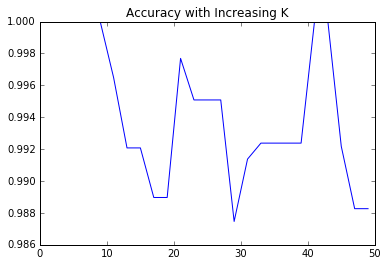

In [52]:
import pylab as pl
from sklearn.neighbors import KNeighborsClassifier
variables = [u'value',u'core_number',
              u'frequency',u'value_video',
              u'shina',u'volume_hdd']
results = []
for n in range(1,51,2):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(train[variables], train[u'Class'])
    preds = clf.predict(test[variables])
    accuracy = np.where(preds==test[u'Class'], 1, 0).sum() / float(len(test))
    print ("Neighbors: %d, Accuracy: %3f" % (n, accuracy))
    results.append([n, accuracy])
results = pd.DataFrame(results, columns=["n", "accuracy"])
pl.plot(results.n, results.accuracy)
pl.title("Accuracy with Increasing K")
pl.show()

выделить максимальное значения для предсказания, код оптимизации, жадные алгоритмы которые не пригодны, алгоритм оптимизации, фильтрация данных(то что не пригодно), генерация с помощью эволюционных алгоритмов, самообучения по эволюционным функциям, по каким критериям будем оценивать нашу конфигурацию, генетический код